In [27]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.stats as stats
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.base import BaseEstimator, ClassifierMixin

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier


from imblearn.over_sampling import SMOTE

# Lectura de los datos

In [28]:
train=pd.read_csv('../data_processed/clean/train_data.csv')

In [29]:
test=pd.read_csv('../data_processed/clean/test_data.csv')

In [30]:
X_train = train.drop('Class', axis=1)
y_train = train['Class']
X_test = test.drop('Class', axis=1)
y_test = test['Class']

Aplicamos una tecnica de balanceo, creando datos sinteticos, denominada como SMOTE para balancear los datos favoreciendo modelos. Solo se aplica sobre los datos de entrenamiento ya que los otros datos no se pueden tocar ya que deben simular la vida real. 

In [31]:
smote=SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Prueba de distintos modelos

In [32]:
# Función para calcular métricas tras la predicción
def classification_metrics(y_test, y_pred, name, model=np.NaN, roc_bool=True):
    """
    Calcula y muestra diversas métricas de clasificación tras realizar una predicción.

    Parámetros:
    -----------
    y_test : array-like
        Valores verdaderos de la variable objetivo (labels) del conjunto de test.
    y_pred : array-like
        Valores predichos por el modelo.
    name : str
        Nombre o descripción del modelo, utilizado para etiquetar la salida.
    model : object, optional
        Modelo utilizado para hacer la predicción. Se utiliza para calcular la métrica
        ROC-AUC si el modelo soporta la función `predict_proba()`. Por defecto, es np.NaN.
    roc_bool : bool, optional
        Variable para pintar (o no) la curva ROC-AUC.

    Métricas calculadas:
    --------------------
    - Accuracy: Precisión del modelo.
    - Matriz de confusión: Representación de los aciertos y errores del modelo.
    - Reporte de clasificación: Incluye precisión, recall, F1-score, etc.
    - ROC-AUC: Se calcula solo si el modelo soporta `predict_proba()`.
    
    Devuelve:
    ---------
    data_metrics : pd.DataFrame
        Dataframe con la información de métricas del modelo evaluado en la función.
    """
    
    # Calcular la precisión (accuracy)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Mostrar resultados
    print(f"\n----- {name} -----")
    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    metrics_summary = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-Score': [], 'ROC-AUC': []}

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Calcular y mostrar ROC-AUC si el modelo lo permite y se pide
    if roc_bool:
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:,1]
            roc_auc = roc_auc_score(y_test, y_proba)
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            print(f"ROC-AUC: {roc_auc:.4f}")
            
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')
            plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
            plt.xlabel('Tasa de Falsos Positivos')
            plt.ylabel('Tasa de Verdaderos Positivos')
            plt.title('Curva ROC')
            plt.legend()
            plt.show()
        
        else:
            print(f"ROC-AUC: No disponible para {name}")

     # Almacenar los resultados en el diccionario
    metrics_summary['Model'].append(name)
    metrics_summary['Accuracy'].append(accuracy)
    metrics_summary['Precision'].append(precision)
    metrics_summary['Recall'].append(recall)
    metrics_summary['F1-Score'].append(f1)
    if roc_bool == True & hasattr(model, "predict_proba"):
        metrics_summary['ROC-AUC'].append(roc_auc)
    else:
        metrics_summary['ROC-AUC'].append(np.NaN)
    
    return pd.DataFrame(metrics_summary)

# Función para entrenar y evaluar modelos
def evaluate_models(models, X_train, X_test, y_train, y_test):
    """
    Entrena y evalúa múltiples modelos de clasificación en un conjunto de datos de prueba.

    Parámetros:
    -----------
    models : dict
        Un diccionario donde las claves son los nombres de los modelos (como cadenas de texto) 
        y los valores son instancias de los modelos de clasificación.
    X_train : array-like
        Características (features) del conjunto de entrenamiento.
    X_test : array-like
        Características (features) del conjunto de prueba.
    y_train : array-like
        Valores verdaderos de la variable objetivo (labels) del conjunto de entrenamiento.
    y_test : array-like
        Valores verdaderos de la variable objetivo (labels) del conjunto de prueba.

    Funcionalidad:
    --------------
    - Entrena cada modelo en `models` usando el conjunto de entrenamiento `X_train` y `y_train`.
    - Predice los valores de la variable objetivo en `X_test` para cada modelo.
    - Calcula y muestra métricas de clasificación (incluyendo accuracy, matriz de confusión, 
      reporte de clasificación y ROC-AUC si está disponible) utilizando la función 
      `classification_metrics`.

    Devuelve:
    ---------
    data_metrics : pd.DataFrame
        Dataframe con la información de métricas de cada modelo evaluado en la función.
    """

    data_metrics = pd.DataFrame()
    
    # Iterar sobre todos los modelos definidos
    for name, model in models.items():
       
        # Entrenar el modelo
        model.fit(X_train, y_train)
        
        # Predecir en los datos de prueba
        y_pred = model.predict(X_test)

        # Sacar métricas
        df_met_model = classification_metrics(y_test, y_pred, name, model)

        # Métricas training
        print("--- MÉTRICAS CON ENTRENAMIENTO: ---")
        df_met_model_train = classification_metrics(y_train, model.predict(X_train), name, model, roc_bool=False)

        # Renombrar columnas de df_met_model_train para concatenar
        df_met_model_train = df_met_model_train.drop(columns=["ROC-AUC"])
        df_met_model_train.rename(columns={col: col + '_train' for col in df_met_model_train.columns if col != 'Model'}, inplace=True)
        
        # Juntar los dos dataframes en uno
        df_met_model = df_met_model.merge(df_met_model_train, left_on='Model', right_on='Model')
        
        if data_metrics.shape[0] > 0:
            data_metrics = pd.concat([data_metrics, df_met_model])
        else:
            data_metrics = df_met_model

    return data_metrics.reset_index(drop=True).loc[:, ['Model', 'Accuracy_train', 'Accuracy', 'Precision_train', 'Precision', 'Recall_train', 'Recall', 'F1-Score_train', 'F1-Score', 'ROC-AUC']]

In [33]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Predicción de 0 siempre
_ = classification_metrics(y_test, np.zeros(len(y_test), dtype='int64'), "Dummy_0")

# Predicción de 1 siempre
_ = classification_metrics(y_test, np.ones(len(y_test), dtype='int64'), "Dummy_1")


----- Dummy_0 -----
Accuracy: 0.9983
Confusion Matrix:
[[56864     0]
 [   98     0]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC: No disponible para Dummy_0

----- Dummy_1 -----
Accuracy: 0.0017
Confusion Matrix:
[[    0 56864]
 [    0    98]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     56864
           1       0.00      1.00      0.00        98

    accuracy                           0.00     56962
   macro avg       0.00      0.50      0.00     56962
weighted avg       0.00      0.00      0.00     56962

ROC-AUC: No disponible para Dummy_1


Podemos ver claramente el desbalanceo en el accuracy de los datos por lo que si no hubiesemos hecho el SMOTE nos habria dado mas datos para el 0.

Vamos a probar ahora distintos modelos para ver como rinden.


----- Logistic Regression -----
Accuracy: 0.8481
Confusion Matrix:
[[48233  8631]
 [   23    75]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.85      0.92     56864
           1       0.01      0.77      0.02        98

    accuracy                           0.85     56962
   macro avg       0.50      0.81      0.47     56962
weighted avg       1.00      0.85      0.92     56962

ROC-AUC: 0.8737


/opt/miniconda3/envs/agg_pml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


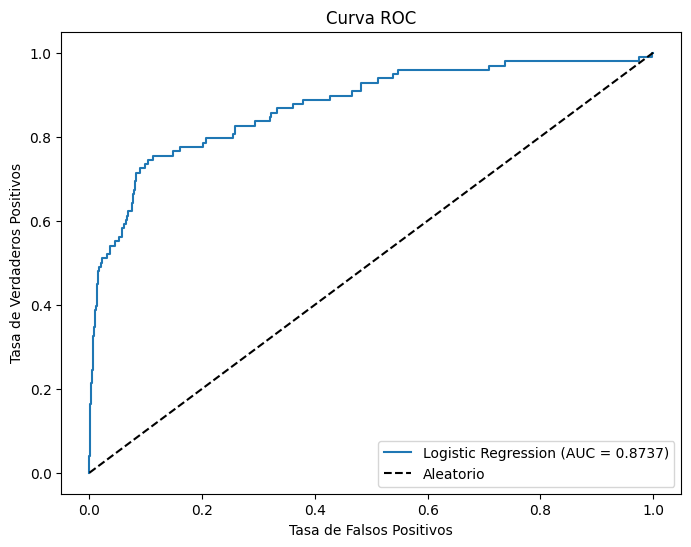

--- MÉTRICAS CON ENTRENAMIENTO: ---

----- Logistic Regression -----
Accuracy: 0.8481
Confusion Matrix:
[[192936  34515]
 [    98    296]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.85      0.92    227451
           1       0.01      0.75      0.02       394

    accuracy                           0.85    227845
   macro avg       0.50      0.80      0.47    227845
weighted avg       1.00      0.85      0.92    227845


----- Random Forest -----
Accuracy: 0.9992
Confusion Matrix:
[[56858     6]
 [   41    57]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.90      0.58      0.71        98

    accuracy                           1.00     56962
   macro avg       0.95      0.79      0.85     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC: 0.9573


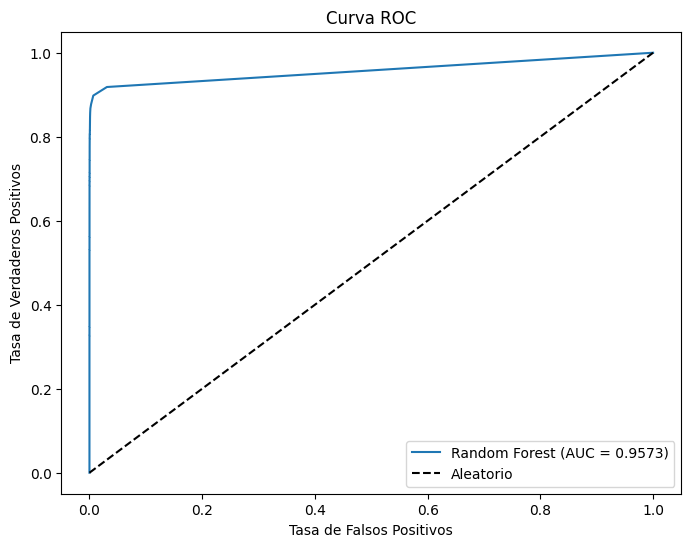

--- MÉTRICAS CON ENTRENAMIENTO: ---

----- Random Forest -----
Accuracy: 1.0000
Confusion Matrix:
[[227451      0]
 [     0    394]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00       394

    accuracy                           1.00    227845
   macro avg       1.00      1.00      1.00    227845
weighted avg       1.00      1.00      1.00    227845


----- Decision Tree -----
Accuracy: 0.9987
Confusion Matrix:
[[56828    36]
 [   36    62]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.63      0.63      0.63        98

    accuracy                           1.00     56962
   macro avg       0.82      0.82      0.82     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC: 0.8160


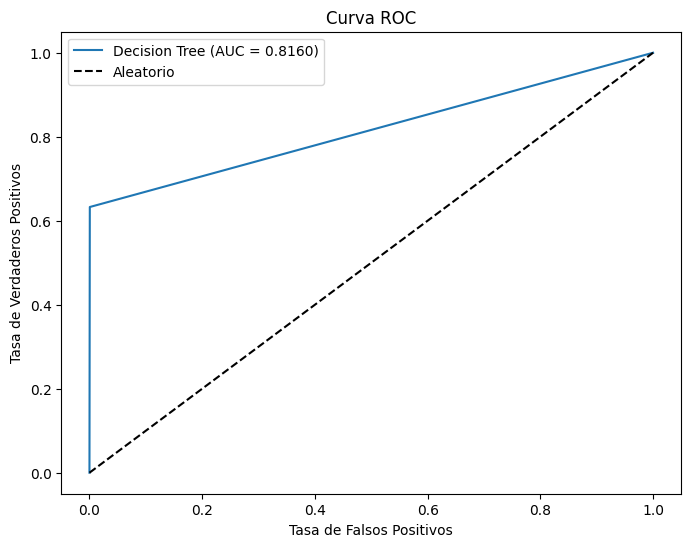

--- MÉTRICAS CON ENTRENAMIENTO: ---

----- Decision Tree -----
Accuracy: 1.0000
Confusion Matrix:
[[227451      0]
 [     0    394]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00       394

    accuracy                           1.00    227845
   macro avg       1.00      1.00      1.00    227845
weighted avg       1.00      1.00      1.00    227845

[LightGBM] [Info] Number of positive: 394, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 227845, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000

----- LightGBM -----
Acc

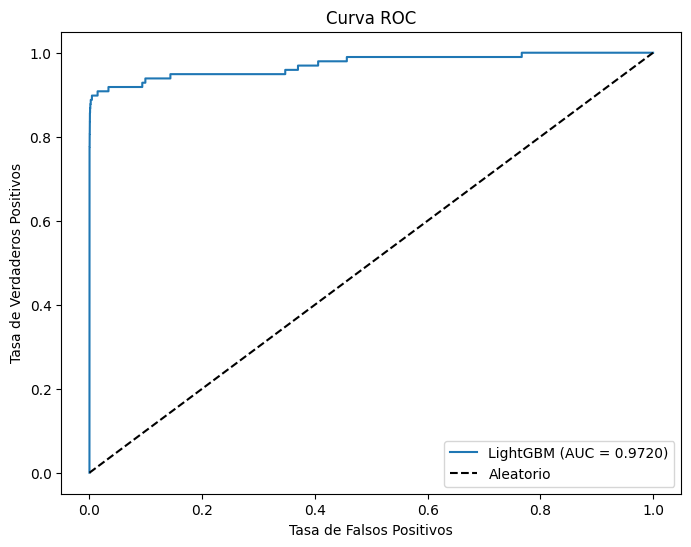

--- MÉTRICAS CON ENTRENAMIENTO: ---

----- LightGBM -----
Accuracy: 0.9997
Confusion Matrix:
[[227379     72]
 [     0    394]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.85      1.00      0.92       394

    accuracy                           1.00    227845
   macro avg       0.92      1.00      0.96    227845
weighted avg       1.00      1.00      1.00    227845



In [34]:
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1, random_state=42),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'LightGBM': LGBMClassifier(class_weight='balanced', random_state=42),
}

metrics_summary = evaluate_models(models, X_train, X_test, y_train, y_test)


In [50]:
metrics_summary.reset_index(drop=True)

,Model,Accuracy_train,Accuracy,Precision_train,Precision,Recall_train,Recall,F1-Score_train,F1-Score,ROC-AUC
0,Logistic Regression,0.827510,0.865753,0.854377,0.009742,0.789603,0.765306,0.820714,0.019238,0.869414
1,Random Forest,1.000000,0.999122,1.000000,0.772727,1.000000,0.693878,1.000000,0.731183,0.953299
2,Decision Tree,1.000000,0.995997,1.000000,0.240000,1.000000,0.612245,1.000000,0.344828,0.804452
3,LightGBM,0.998560,0.996454,0.997129,0.305970,1.000000,0.836735,0.998562,0.448087,0.973643
4,Best Random Forest - Optimized,0.998543,0.998402,0.969697,1.000000,0.162437,0.071429,0.278261,0.133333,0.966862
5,Best Random Forest - Optimized,0.998398,0.998332,1.000000,1.000000,0.073604,0.030612,0.137116,0.059406,0.971129



----- Logistic Regression -----
Accuracy: 0.8658
Confusion Matrix:
[[49240  7624]
 [   23    75]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.87      0.93     56864
           1       0.01      0.77      0.02        98

    accuracy                           0.87     56962
   macro avg       0.50      0.82      0.47     56962
weighted avg       1.00      0.87      0.93     56962

ROC-AUC: 0.8694


/opt/miniconda3/envs/agg_pml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


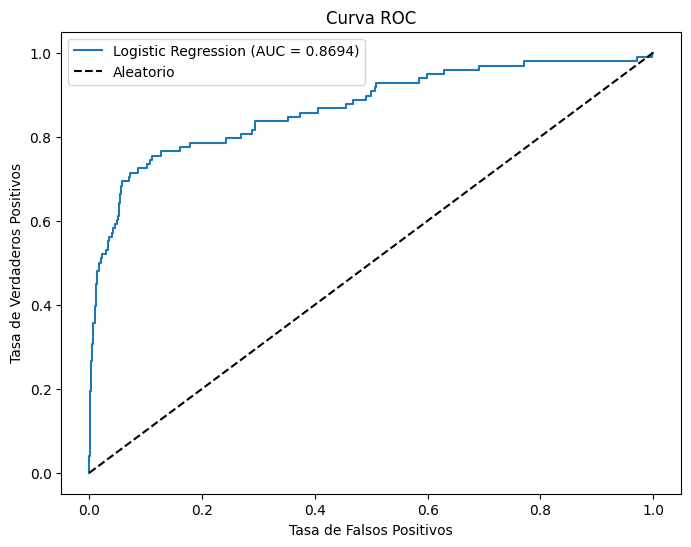

--- MÉTRICAS CON ENTRENAMIENTO: ---

----- Logistic Regression -----
Accuracy: 0.8275
Confusion Matrix:
[[196840  30611]
 [ 47855 179596]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.87      0.83    227451
           1       0.85      0.79      0.82    227451

    accuracy                           0.83    454902
   macro avg       0.83      0.83      0.83    454902
weighted avg       0.83      0.83      0.83    454902


----- Random Forest -----
Accuracy: 0.9991
Confusion Matrix:
[[56844    20]
 [   30    68]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.77      0.69      0.73        98

    accuracy                           1.00     56962
   macro avg       0.89      0.85      0.87     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC: 0.9533


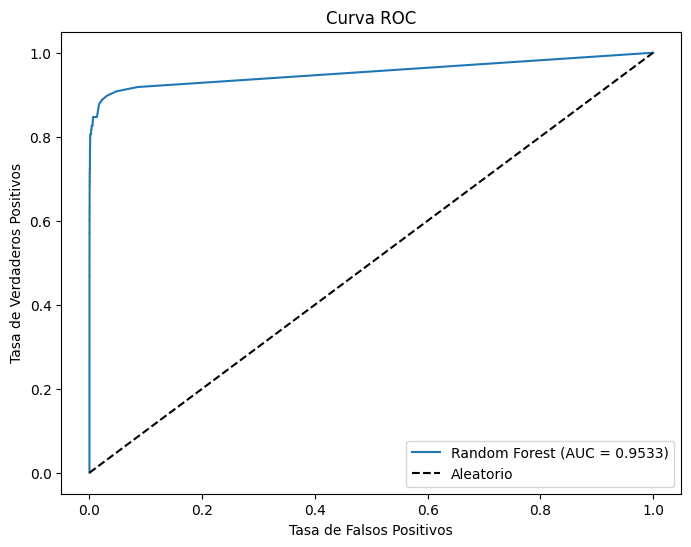

--- MÉTRICAS CON ENTRENAMIENTO: ---

----- Random Forest -----
Accuracy: 1.0000
Confusion Matrix:
[[227451      0]
 [     0 227451]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00    227451

    accuracy                           1.00    454902
   macro avg       1.00      1.00      1.00    454902
weighted avg       1.00      1.00      1.00    454902


----- Decision Tree -----
Accuracy: 0.9960
Confusion Matrix:
[[56674   190]
 [   38    60]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.24      0.61      0.34        98

    accuracy                           1.00     56962
   macro avg       0.62      0.80      0.67     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC: 0.8045


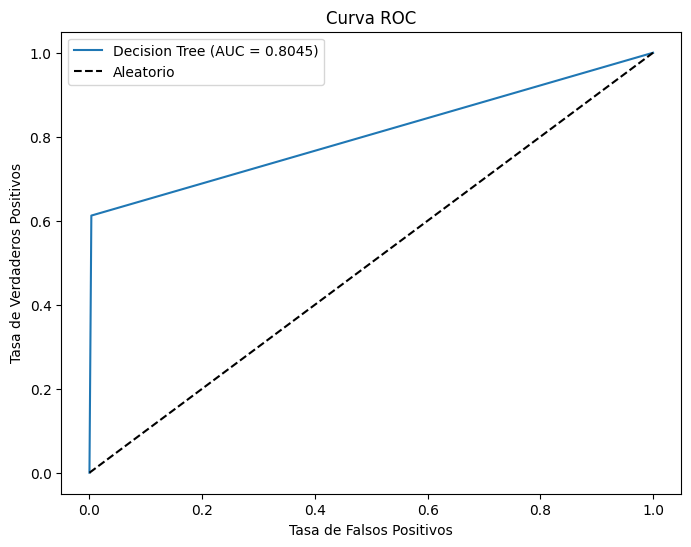

--- MÉTRICAS CON ENTRENAMIENTO: ---

----- Decision Tree -----
Accuracy: 1.0000
Confusion Matrix:
[[227451      0]
 [     0 227451]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00    227451

    accuracy                           1.00    454902
   macro avg       1.00      1.00      1.00    454902
weighted avg       1.00      1.00      1.00    454902

[LightGBM] [Info] Number of positive: 227451, number of negative: 227451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 454902, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

----- Ligh

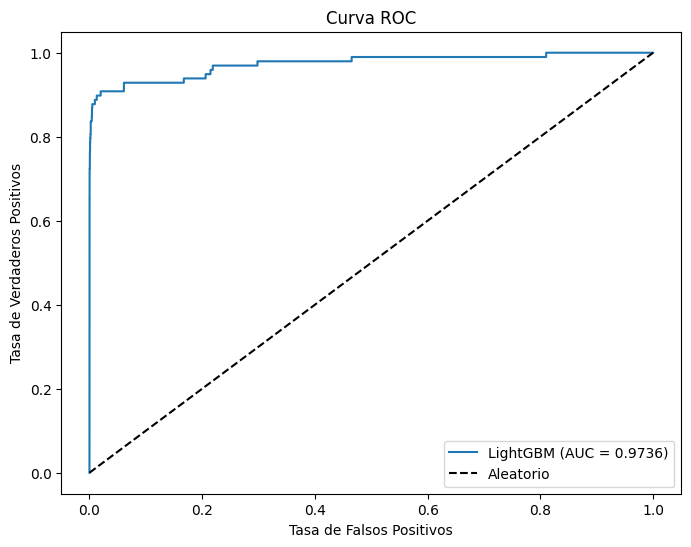

--- MÉTRICAS CON ENTRENAMIENTO: ---

----- LightGBM -----
Accuracy: 0.9986
Confusion Matrix:
[[226796    655]
 [     0 227451]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00    227451

    accuracy                           1.00    454902
   macro avg       1.00      1.00      1.00    454902
weighted avg       1.00      1.00      1.00    454902



In [36]:
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1,random_state=42),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'LightGBM': LGBMClassifier(class_weight='balanced', random_state=42),
}

metrics_summary=evaluate_models(models,X_train_bal, X_test,y_train_bal, y_test )

In [37]:
metrics_summary.reset_index(drop=True)

,Model,Accuracy_train,Accuracy,Precision_train,Precision,Recall_train,Recall,F1-Score_train,F1-Score,ROC-AUC
0,Logistic Regression,0.82751,0.865753,0.854377,0.009742,0.789603,0.765306,0.820714,0.019238,0.869414
1,Random Forest,1.00000,0.999122,1.000000,0.772727,1.000000,0.693878,1.000000,0.731183,0.953299
2,Decision Tree,1.00000,0.995997,1.000000,0.240000,1.000000,0.612245,1.000000,0.344828,0.804452
3,LightGBM,0.99856,0.996454,0.997129,0.305970,1.000000,0.836735,0.998562,0.448087,0.973643


# Estudio de pesos de caracteristicas

## Regresión logística

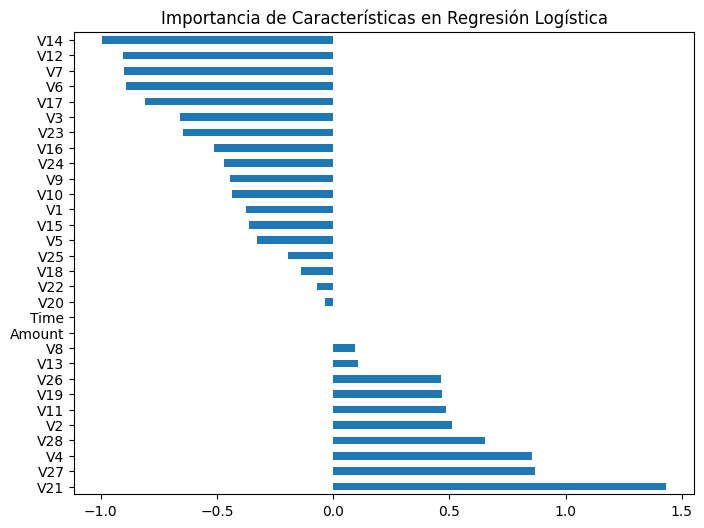

In [38]:
logreg = models["Logistic Regression"]

# Obtener los coeficientes del modelo
feature_importance = pd.Series(logreg.coef_[0], index=X_train.columns)

# Ordenar las características por importancia
feature_importance = feature_importance.sort_values(ascending=False)

# Graficar los coeficientes
plt.figure(figsize=(8, 6))
feature_importance.plot(kind='barh')
plt.title('Importancia de Características en Regresión Logística')
plt.show()

## Árbol de decisión

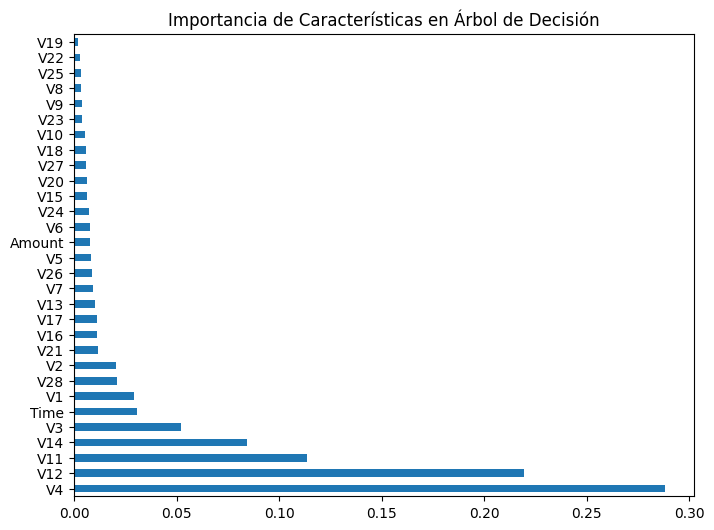

In [39]:
dt = models["Decision Tree"]

# Obtener las importancias de las características
feature_importance_dt = pd.Series(dt.feature_importances_, index=X_train.columns)

# Ordenar las características por importancia
feature_importance_dt = feature_importance_dt.sort_values(ascending=False)

# Graficar las importancias
plt.figure(figsize=(8, 6))
feature_importance_dt.plot(kind='barh')
plt.title('Importancia de Características en Árbol de Decisión')
plt.show()

## Random Forrest

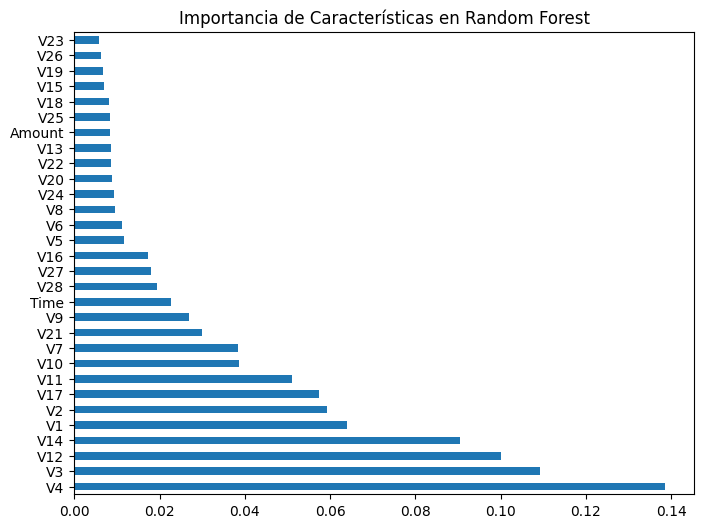

In [40]:
rf = models["Random Forest"]

# Obtener las importancias de las características
feature_importance_rf = pd.Series(rf.feature_importances_, index=X_train.columns)

# Ordenar las características por importancia
feature_importance_rf = feature_importance_rf.sort_values(ascending=False)

# Graficar las importancias
plt.figure(figsize=(8, 6))
feature_importance_rf.plot(kind='barh')
plt.title('Importancia de Características en Random Forest')
plt.show()

## LightGBM

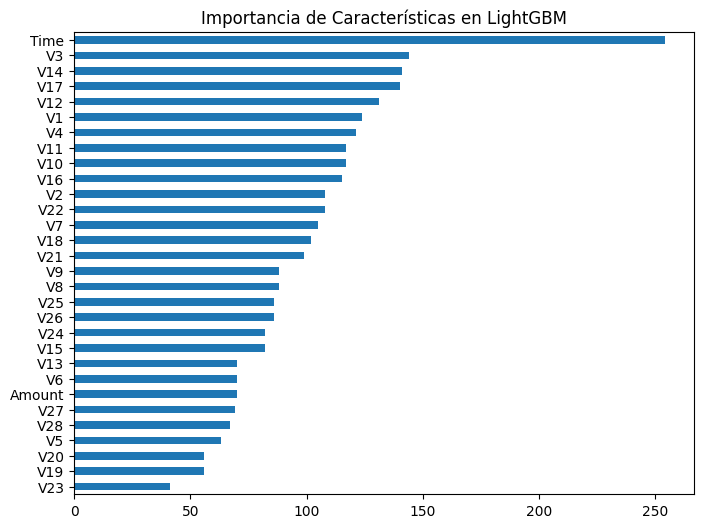

In [41]:
# Supongamos que tu modelo LightGBM ya está entrenado
lgbm = models["LightGBM"]

# Obtener las importancias de las características
feature_importance_lgbm = pd.Series(lgbm.feature_importances_, index=X_train.columns)

# Ordenar las características por importancia
feature_importance_lgbm = feature_importance_lgbm.sort_values(ascending=False)

# Graficar las importancias
plt.figure(figsize=(8, 6))
feature_importance_lgbm.plot(kind='barh')
plt.title('Importancia de Características en LightGBM')
plt.gca().invert_yaxis()  # Opcional: para que las más importantes estén arriba
plt.show()


# Optimizacion de los modelos

## Random Forrest

In [47]:
param_grid_rf = {
    'n_estimators': [50, 100],        
    'max_depth': [5, 7],              
    'min_samples_split': [4, 6],      
    'bootstrap': [True],             
    'criterion': ["gini"]            
}


# Aplicar GridSearchCV
start_time = time.time()  # Iniciar el temporizador
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='roc_auc', verbose=3, return_train_score=True)
grid_search_rf.fit(X_train, y_train)

# Detener el temporizador y calcular el tiempo transcurrido
end_time = time.time()
elapsed_time = end_time - start_time
print(f"El tiempo total de ejecución fue: {elapsed_time:.2f} segundos")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END bootstrap=True, criterion=gini, max_depth=5, min_samples_split=4, n_estimators=50;, score=(train=0.989, test=0.948) total time=  12.5s
[CV 2/5] END bootstrap=True, criterion=gini, max_depth=5, min_samples_split=4, n_estimators=50;, score=(train=0.983, test=0.972) total time=  12.7s
[CV 3/5] END bootstrap=True, criterion=gini, max_depth=5, min_samples_split=4, n_estimators=50;, score=(train=0.984, test=0.974) total time=  12.8s
[CV 4/5] END bootstrap=True, criterion=gini, max_depth=5, min_samples_split=4, n_estimators=50;, score=(train=0.986, test=0.954) total time=  12.9s
[CV 5/5] END bootstrap=True, criterion=gini, max_depth=5, min_samples_split=4, n_estimators=50;, score=(train=0.983, test=0.975) total time=  12.9s
[CV 1/5] END bootstrap=True, criterion=gini, max_depth=5, min_samples_split=4, n_estimators=100;, score=(train=0.993, test=0.949) total time=  25.8s
[CV 2/5] END bootstrap=True, criterion=gini, max_de

In [48]:
# Mostrar los mejores parámetros y la mejor puntuación obtenida
print("\nMejores parámetros para Random Forest:")
print(grid_search_rf.best_params_)
print(f"Mejor precisión en validación cruzada: {grid_search_rf.best_score_:.4f}")

# Evaluar el modelo ajustado en el conjunto de prueba
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
print(f"Precisión del mejor Random Forest en el conjunto de prueba: {accuracy_score(y_test, y_pred_rf):.4f}")


Mejores parámetros para Random Forest:
{'bootstrap': True, 'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 4, 'n_estimators': 100}
Mejor precisión en validación cruzada: 0.9721
Precisión del mejor Random Forest en el conjunto de prueba: 0.9983



----- Best Random Forest - Optimized -----
Accuracy: 0.9983
Confusion Matrix:
[[56864     0]
 [   95     3]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       1.00      0.03      0.06        98

    accuracy                           1.00     56962
   macro avg       1.00      0.52      0.53     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC: 0.9711


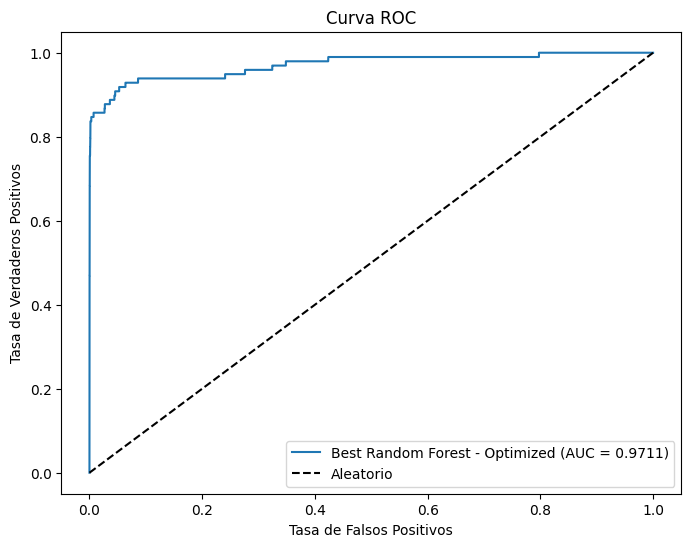


----- Best Random Forest - Optimized -----
Accuracy: 0.9984
Confusion Matrix:
[[227451      0]
 [   365     29]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      0.07      0.14       394

    accuracy                           1.00    227845
   macro avg       1.00      0.54      0.57    227845
weighted avg       1.00      1.00      1.00    227845



,Model,Accuracy_train,Accuracy,Precision_train,Precision,Recall_train,Recall,F1-Score_train,F1-Score,ROC-AUC
0,Logistic Regression,0.827510,0.865753,0.854377,0.009742,0.789603,0.765306,0.820714,0.019238,0.869414
1,Random Forest,1.000000,0.999122,1.000000,0.772727,1.000000,0.693878,1.000000,0.731183,0.953299
2,Decision Tree,1.000000,0.995997,1.000000,0.240000,1.000000,0.612245,1.000000,0.344828,0.804452
3,LightGBM,0.998560,0.996454,0.997129,0.305970,1.000000,0.836735,0.998562,0.448087,0.973643
4,Best Random Forest - Optimized,0.998543,0.998402,0.969697,1.000000,0.162437,0.071429,0.278261,0.133333,0.966862
5,Best Random Forest - Optimized,0.998398,0.998332,1.000000,1.000000,0.073604,0.030612,0.137116,0.059406,0.971129
6,Best LightGBM - Optimized,0.999179,0.998086,0.678141,0.467456,1.000000,0.806122,0.808205,0.591760,0.958601
7,Best LightGBM - Optimized,0.999179,0.998086,0.678141,0.467456,1.000000,0.806122,0.808205,0.591760,0.958601
8,Best LightGBM - Optimized,0.999179,0.998086,0.678141,0.467456,1.000000,0.806122,0.808205,0.591760,0.958601
9,Best Random Forest - Optimized,0.998398,0.998332,1.000000,1.000000,0.073604,0.030612,0.137116,0.059406,0.971129


In [59]:
df_met_bestrf= classification_metrics(y_test, y_pred_rf, "Best Random Forest - Optimized", model=best_rf, roc_bool=True)
df_met_bestrf_train= classification_metrics(y_train, best_rf.predict(X_train), "Best Random Forest - Optimized", model=best_rf, roc_bool=False)

# Renombrar columnas de df_met_model_train para concatenar
df_met_bestrf_train = df_met_bestrf_train.drop(columns=["ROC-AUC"])
df_met_bestrf_train.rename(columns={col: col + '_train' for col in df_met_bestrf_train.columns if col != 'Model'}, inplace=True)

# Juntar los dos dataframes en uno
df_met_bestrf = df_met_bestrf.merge(df_met_bestrf_train, left_on='Model', right_on='Model')

metrics_summary = pd.concat([metrics_summary, df_met_bestrf])
    
metrics_summary.reset_index(drop=True)

Exportamos el mejor modelo

In [53]:
# Exportar mejor Random Forest
filename = '../modelos/random_forest.pkl'
pickle.dump(best_rf, open(filename, 'wb'))

# LightGBM

In [54]:
# Definir hiperparámetros para GridSearch
param_grid_lgbm = {
    'n_estimators': [100, 150],       
    'max_depth': [5, 7],             
    'num_leaves': [31, 50],           
    'learning_rate': [0.05, 0.1],    
    'boosting_type': ['gbdt']         
}

# Modelo base
lgbm = LGBMClassifier(
    objective='binary', 
    random_state=42,
    n_jobs=-1
)

# Aplicar GridSearchCV
start_time = time.time()  
grid_search_lgbm = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid_lgbm,
    cv=5,
    scoring='roc_auc', 
    verbose=3,
    return_train_score=True
)

# Ajustar
grid_search_lgbm.fit(X_train_bal, y_train_bal)

# Detener temporizador y mostrar tiempo
end_time = time.time()
elapsed_time = end_time - start_time
print(f"El tiempo total de ejecución fue: {elapsed_time:.2f} segundos")


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[LightGBM] [Info] Number of positive: 181961, number of negative: 181960
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 363921, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500001 -> initscore=0.000005
[LightGBM] [Info] Start training from score 0.000005
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV 1/5] END boosting_type=gbdt, learning_rate=0.05, max_depth=5, n_estimators=100, num_leaves=31;, score=(train=0.999, test=0.999) total time=   0.9s
[LightGBM] [Info] Number of positive: 181960, number of negative: 181961
[Light

In [55]:
# Mostrar los mejores parámetros y la mejor puntuación obtenida
print("\nMejores parámetros para LightGBM:")
print(grid_search_lgbm.best_params_)
print(f"Mejor ROC-AUC en validación cruzada: {grid_search_lgbm.best_score_:.4f}")

# Evaluar el modelo ajustado en el conjunto de prueba
best_lgbm = grid_search_lgbm.best_estimator_
y_pred_lgbm = best_lgbm.predict(X_test)
print(f"Precisión del mejor LightGBM en el conjunto de prueba: {accuracy_score(y_test, y_pred_lgbm):.4f}")



Mejores parámetros para LightGBM:
{'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150, 'num_leaves': 50}
Mejor ROC-AUC en validación cruzada: 1.0000
Precisión del mejor LightGBM en el conjunto de prueba: 0.9981



----- Best LightGBM - Optimized -----
Accuracy: 0.9981
Confusion Matrix:
[[56774    90]
 [   19    79]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.47      0.81      0.59        98

    accuracy                           1.00     56962
   macro avg       0.73      0.90      0.80     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC: 0.9586


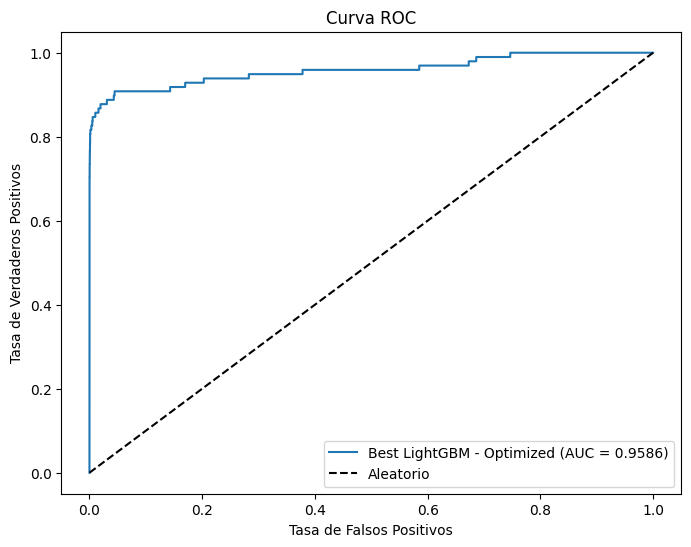


----- Best LightGBM - Optimized -----
Accuracy: 0.9992
Confusion Matrix:
[[227264    187]
 [     0    394]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.68      1.00      0.81       394

    accuracy                           1.00    227845
   macro avg       0.84      1.00      0.90    227845
weighted avg       1.00      1.00      1.00    227845



In [60]:
# Calcular métricas para el mejor LightGBM en test y en train
df_met_bestlgbm = classification_metrics(y_test, y_pred_lgbm, "Best LightGBM - Optimized", model=best_lgbm, roc_bool=True)
df_met_bestlgbm_train = classification_metrics(y_train, best_lgbm.predict(X_train), "Best LightGBM - Optimized", model=best_lgbm, roc_bool=False)

# Renombrar columnas del train para poder unir
df_met_bestlgbm_train = df_met_bestlgbm_train.drop(columns=["ROC-AUC"])
df_met_bestlgbm_train.rename(columns={col: col + '_train' for col in df_met_bestlgbm_train.columns if col != 'Model'}, inplace=True)

# Juntar los dos dataframes
df_met_bestlgbm = df_met_bestlgbm.merge(df_met_bestlgbm_train, left_on='Model', right_on='Model')

# Añadir al resumen general
metrics_summary = pd.concat([metrics_summary, df_met_bestlgbm])

# Resetear el índice
metrics_summary.reset_index(drop=True, inplace=True)


In [61]:
metrics_summary

,Model,Accuracy_train,Accuracy,Precision_train,Precision,Recall_train,Recall,F1-Score_train,F1-Score,ROC-AUC
0,Logistic Regression,0.827510,0.865753,0.854377,0.009742,0.789603,0.765306,0.820714,0.019238,0.869414
1,Random Forest,1.000000,0.999122,1.000000,0.772727,1.000000,0.693878,1.000000,0.731183,0.953299
2,Decision Tree,1.000000,0.995997,1.000000,0.240000,1.000000,0.612245,1.000000,0.344828,0.804452
3,LightGBM,0.998560,0.996454,0.997129,0.305970,1.000000,0.836735,0.998562,0.448087,0.973643
4,Best Random Forest - Optimized,0.998543,0.998402,0.969697,1.000000,0.162437,0.071429,0.278261,0.133333,0.966862
5,Best Random Forest - Optimized,0.998398,0.998332,1.000000,1.000000,0.073604,0.030612,0.137116,0.059406,0.971129
6,Best LightGBM - Optimized,0.999179,0.998086,0.678141,0.467456,1.000000,0.806122,0.808205,0.591760,0.958601
7,Best LightGBM - Optimized,0.999179,0.998086,0.678141,0.467456,1.000000,0.806122,0.808205,0.591760,0.958601
8,Best LightGBM - Optimized,0.999179,0.998086,0.678141,0.467456,1.000000,0.806122,0.808205,0.591760,0.958601
9,Best Random Forest - Optimized,0.998398,0.998332,1.000000,1.000000,0.073604,0.030612,0.137116,0.059406,0.971129


In [62]:
# Exportar mejor ligthgbm
filename = '../modelos/lightgbm.pkl'
pickle.dump(best_lgbm, open(filename, 'wb'))